In [1]:
import pandas as pd
import regex as re
from tqdm import tqdm_notebook
import os
import shutil
import matplotlib.pyplot as plt
import artm
import codecs
from seaborn import heatmap
import time
from math import log
import operator
import numpy as np
from nltk import sent_tokenize
from pymystem3 import Mystem
from tools import *
from preprocess_line import CollocationSyntax, add_collocation, lemmatize
from create_ww_and_pmi_count import main as prepare_vw_wntm_pmi_vocab
import pickle
%matplotlib inline
tqdm_notebook().pandas(tqdm_notebook())

A Jupyter Widget

A Jupyter Widget

In [2]:
FOLDER_DATA = "rsb/"
REPLIES = FOLDER_DATA + "replies.pkl"
SENTENCES_REPLIES = FOLDER_DATA + "sentences_replies.pkl"
PATH_JSON = "tutorial/banks.json"
FOLDER_BATCHES = FOLDER_DATA + 'batches/'
BRANCHES = FOLDER_DATA + "branches.pkl"
COLLOCATIONS = FOLDER_DATA + "collocations.txt"
SENTIMENT_PATH = FOLDER_DATA + "collection (docs&words)_2016_all_labels/full word_rating_after_coding.xlsx"

COLUMN_REPLY_ID = "reply_id"
COLUMN_VOCAB_ONLY = "vocab_only"
COLUMN_SENTENCE = "sentence"
COLUMN_DELETE_EXTRA_SYMBOLS = "deleted_extra_symbols"
COLUMN_LEMMATIZED = "lemmatized"
COLUMN_VOCAB_ONLY = "vocab_only"

SYNTAXNET_INPUT = FOLDER_DATA + "to_syntaxnet.txt"
SYNTAXNET_OUTPUT = FOLDER_DATA + "from_syntaxnet.txt"
SYNTAXNET_MODELS_PATH = "~/Python_libs/models/syntaxnet/syntaxnet"
SYNTAXNET_OUTPUT_PKL = "from_syntaxnet.pkl"

In [3]:
replies = pd.read_pickle(REPLIES)

In [4]:
replies.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
852,19an73,rsb,None,1,0,оценка: 1 проверяется,"Я был клиентом банка очень длительное время, н...",06.04.2017 20:50,Верх цинизма,1
885,seodoriseodori,rsb,None,1,0,оценка: 5 проверяется,Сегодня посетил свое любимое отделение на Октя...,06.04.2017 19:47,Переоформление вклада и сотрудники сбора проср...,5
886,ladida1,rsb,None,1,1,оценка: 3 проверяется,Добрый день! Являюсь держателем кредитной карт...,06.04.2017 13:44,Невозможно потратить Кэшбек бонусы в течение 2...,3
887,Igor636,rsb,None,1,0,без оценки,"Являюсь обладателем ""зелёной"" дебетовой карты ...",06.04.2017 12:08,"Вопрос про ""неуловимые"" бонусы",-1
923,JVV2017,rsb,None,1,1,оценка: 1 проверяется,Добрый день! У меня есть просрочка по потреб...,05.04.2017 19:18,Хамство и угрозы со стороны банка,1


In [5]:
#Посмотрим на число отзывов для банка
replies.bank.value_counts()

rsb    15173
Name: bank, dtype: int64

In [6]:
gb = replies.groupby(['mark'])

In [7]:
for key, value in dict(gb.size()).items():
    print "mark: ", key, "number of comments: ", value

mark:  1 number of comments:  5567
mark:  2 number of comments:  1280
mark:  3 number of comments:  790
mark:  4 number of comments:  306
mark:  5 number of comments:  1556
mark:  -1 number of comments:  5674


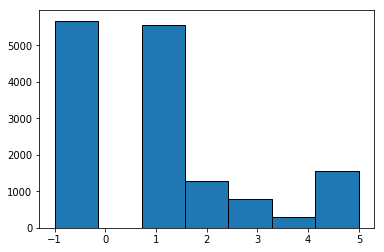

In [8]:
plt.hist(replies.mark, bins=7, edgecolor='k')
plt.show()

In [9]:
#Посмотрим как распределены комментарии
comment_frequency = replies.author.value_counts()
print comment_frequency[comment_frequency > 1].value_counts()

2     1088
3      307
4      109
5       57
6       33
7       15
8        5
11       5
9        4
10       4
12       2
13       2
28       1
14       1
19       1
20       1
25       1
65       1
Name: author, dtype: int64


In [10]:
replies = pd.read_pickle(REPLIES)

In [11]:
#Изменяю столбец со временем, убираю часы-минут, и день
replies_my = dict(replies.time.copy())
for index, time in replies_my.items():
    k = str(time).split(' ')
    k = k[0].split('.')
    k = k[2]
    replies_my[index] = k
for key, value in replies_my.items():
    replies.loc[key, 'time'] = value

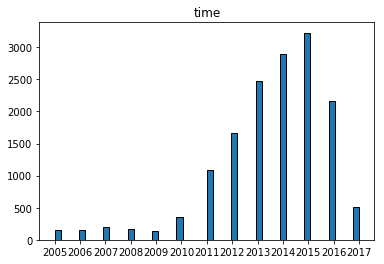

In [12]:
#Ответы по годам
plt.hist(replies['time'], bins='auto', edgecolor='k')
plt.title('time')
plt.show()

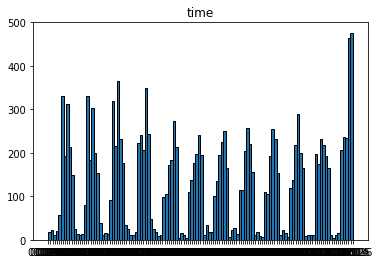

In [13]:
#По месяцам 
replies = pd.read_pickle(REPLIES)
replies_my_month = dict(replies.time.copy())
for index, time in replies_my_month.items():
    k = str(time).split(' ')
    k = k[0].split('.')
    k = k[1] + '.' + k[2]
    replies_my[index] = k

for key, value in replies_my.items():
    replies.loc[key, 'time'] = value

plt.hist(replies['time'], bins=120, edgecolor='k')
plt.title('time')
plt.show()

Вряд ли данные по месяцам являются информативными, просто видно, что в какие-то месяца люди более активно писали комментарии, в какие-то почти не писали. 

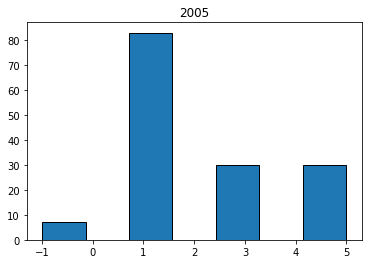

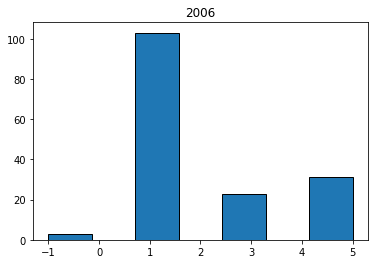

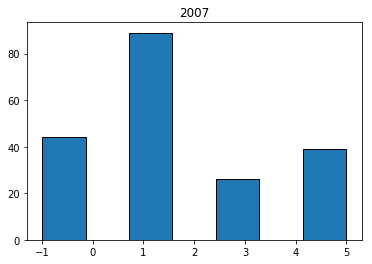

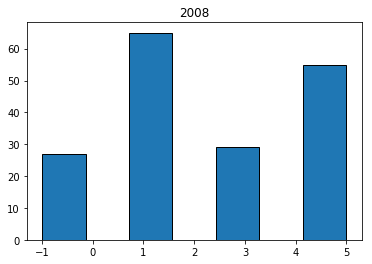

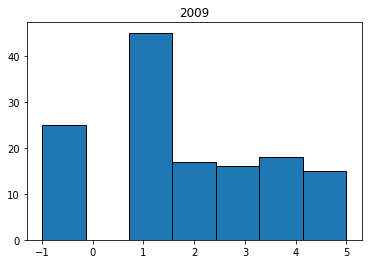

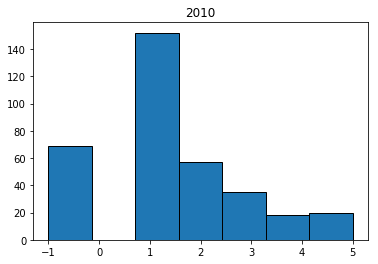

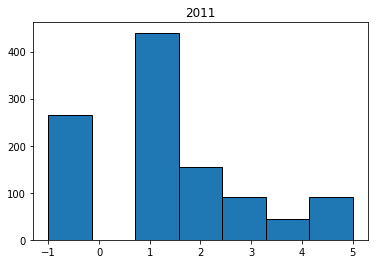

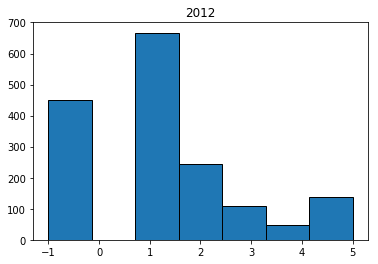

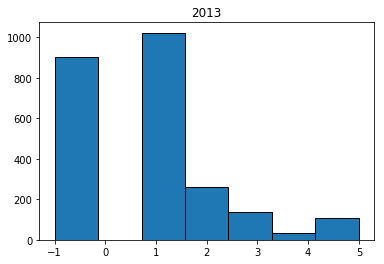

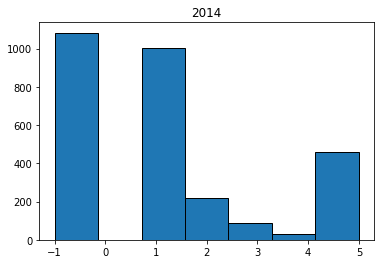

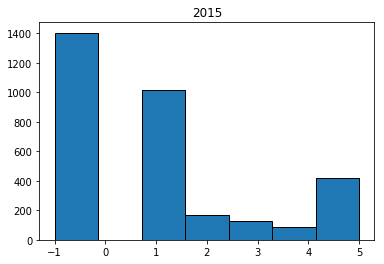

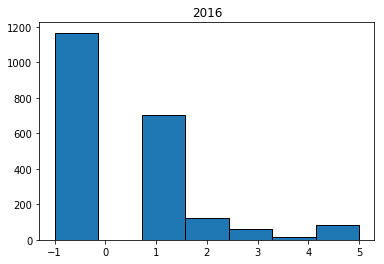

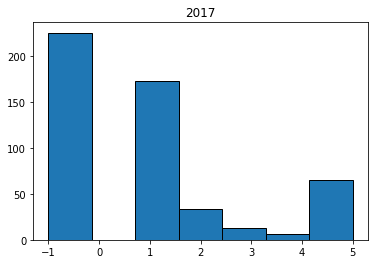

In [14]:
#Если рассмотреть гистограммы оценок по годам
replies = pd.read_pickle(REPLIES)
replies_my_year = dict(replies.time.copy())

for index, time in replies_my_year.items():
    k = str(time).split(' ')
    k = k[0].split('.')
    replies_my[index] = k[2]

for key, value in replies_my.items():
    replies.loc[key, 'time'] = value

df = replies.groupby(['time'])
for i in df:
    plt.hist(i[1].mark, bins=7, edgecolor='k')
    plt.title(i[0])
    plt.show()

Видно, что столбце с оценкой 1 всегда остается самым высоким, но при этом в некоторые года происходит рост оценок 4, 5. В какой то год примерно всех оценок было поровну, кроме 1 (2009 год). Если посомтреть на общее число комментариев по годам, то с 2015 года комментарии стали писать меньше, при этом с 2016 года по 2017 год произошле рост положительных оценок. Но отрицательные отзывы продолжают преобладать на всем временном отрезке. Поэтому можно предположить, что происходит отток клиентов, т.к. общее число комментариев с 2015 года падает, а число отризацетльных оценок не сильно уменьшается относительно других, поэтому вряд ли банк каким-то образом решает возникшие проблемы. 

In [15]:
#Посмотрим на наиболее активных пользователей
pd.set_option("display.max_rows", 100)
replies[replies.author.isin(comment_frequency[comment_frequency > 10].index)].groupby(
    ["author"])["mark"].value_counts().unstack(fill_value=0).head(100)

mark,-1,1,2,3,4,5
author,,,,,,
Complince,3,9,0,5,0,3
Helenspb78,43,7,2,6,2,5
Howell,5,3,1,2,0,0
NMichel,17,5,1,1,1,0
RIR,6,1,2,0,2,1
Roman0084,8,2,2,0,0,2
df82,4,8,0,0,0,1
lauger,13,4,0,1,0,1
prt,5,2,0,2,0,2


In [16]:
#Хочу завести два словаря, один, в котором будет имя пользователя и 
#дата комментария для оценок 1-2, в другом с оценками 4-5. Затем пройдусь по одному из словарей,
#смотрю есть ли такое жи имя в другом словаре и пишу даты комментарией
replies_my = pd.read_pickle(REPLIES)
replies_my_time = dict(replies_my.time.copy())

for index, time in replies_my_time.items():
    k = str(time).split(' ')
    k = k[0]
    replies_my_time[index] = k
for key, value in replies_my_time.items():
    replies_my.loc[key, 'time'] = value

mark_1_2 = {}
mark_4_5 = {}
for i in replies_my.index:
    mark = replies_my.loc[i, 'mark']
    author = replies_my.loc[i, 'author']
    if mark == 1 or mark == 2:
        if mark_1_2.get(author) == None:
            mark_1_2.update([(author, replies_my.loc[i, 'time'])])
        else:
            mark_1_2[author] += '; ' + replies_my.loc[i, 'time']
    if mark == 4 or mark == 5:
        if mark_4_5.get(author) == None:
            mark_4_5.update([(author, str(replies_my.loc[i, 'time']))])
        else:
            mark_4_5[author] += '; ' + replies_my.loc[i, 'time']

In [17]:
k = 0
for i in mark_1_2:
    if mark_4_5.get(i) != None:
        k += 1
        print i
        print "Негативный отзывы: ", mark_1_2[i]
        print "Позитивные отзывы: ", mark_4_5[i]

LesyaS
Негативный отзывы:  05.03.2012
Позитивные отзывы:  19.07.2012
неизвестный
Негативный отзывы:  28.08.2006; 06.04.2006
Позитивные отзывы:  19.07.2006; 20.03.2006
MaxsVrn
Негативный отзывы:  30.11.2015
Позитивные отзывы:  13.02.2017
Татьяна031261
Негативный отзывы:  29.09.2015
Позитивные отзывы:  17.02.2015
alex_nik
Негативный отзывы:  11.01.2017
Позитивные отзывы:  24.11.2012
makar.61
Негативный отзывы:  24.12.2010
Позитивные отзывы:  01.09.2011
Muhtarchik
Негативный отзывы:  12.12.2012; 19.08.2011
Позитивные отзывы:  03.08.2011
q1234e
Негативный отзывы:  11.02.2011
Позитивные отзывы:  26.02.2012
Вячеслав
Негативный отзывы:  29.06.2005
Позитивные отзывы:  03.11.2005
ois1977
Негативный отзывы:  28.02.2013
Позитивные отзывы:  01.04.2012
AZhur
Негативный отзывы:  02.10.2014; 21.08.2013
Позитивные отзывы:  03.09.2013
gocha651213
Негативный отзывы:  25.11.2013; 24.09.2013
Позитивные отзывы:  30.11.2013; 09.10.2013; 10.09.2013; 23.07.2013
iamgeniy
Негативный отзывы:  03.12.2015
Позитивн

Сложно сказать, улучшилась работа банка или ухудшилась. Т.к. всего 158 человек, которые указывали противоречивые отзывы, но при этом есть люди, у которых сначала был негативный отзыв, затем позитивный, так и наоборот. Есть люди у которы такие отзывы чередуются. У некоторых клиентов отзывы были в течение одного года, у некоторых противоречивые отзывы были с большим промежутком по времени. 

In [18]:
#Смотрим заголовки отзывов
replies.title.value_counts()[:20]

Благодарность                                                 93
Жалоба                                                        51
Транспортная карта                                            46
Претензия                                                     42
Телефонный терроризм                                          30
Звонки из банка                                               29
Мой отзыв                                                     26
Взыскание задолженности                                       25
Звонки                                                        24
Отличный банк                                                 23
Кредитная карта                                               23
Угрозы                                                        23
Банк в кармане                                                22
Блокировка карты                                              21
Банкомат съел деньги                                          21
Реструктуризация         

In [19]:
print "Уникальных {} ответов из {}".format(len(replies.bank_response.unique()), len(replies.bank_response))

Уникальных 10346 ответов из 15173


Неуникальность ответов может быть связана с тем, что если отзыв был положительный, то скорее всего отвечали одинаково, могла быть просто благодарность за отзыв. Также на какие-то негативные отзывы ответы могли повторять, что банк общает исправит данную проблему.

In [20]:
print "Уникальных {} отзывов из {}".format(len(replies.text.unique()), len(replies.text))

Уникальных 15170 отзывов из 15173


In [21]:
replies = pd.read_pickle(REPLIES)
sentences_replies = pd.read_pickle(SENTENCES_REPLIES)
branches_data = pd.read_pickle(BRANCHES)

In [22]:
replies.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
852,19an73,rsb,None,1,0,оценка: 1 проверяется,"Я был клиентом банка очень длительное время, н...",06.04.2017 20:50,Верх цинизма,1
885,seodoriseodori,rsb,None,1,0,оценка: 5 проверяется,Сегодня посетил свое любимое отделение на Октя...,06.04.2017 19:47,Переоформление вклада и сотрудники сбора проср...,5
886,ladida1,rsb,None,1,1,оценка: 3 проверяется,Добрый день! Являюсь держателем кредитной карт...,06.04.2017 13:44,Невозможно потратить Кэшбек бонусы в течение 2...,3
887,Igor636,rsb,None,1,0,без оценки,"Являюсь обладателем ""зелёной"" дебетовой карты ...",06.04.2017 12:08,"Вопрос про ""неуловимые"" бонусы",-1
923,JVV2017,rsb,None,1,1,оценка: 1 проверяется,Добрый день! У меня есть просрочка по потреб...,05.04.2017 19:18,Хамство и угрозы со стороны банка,1


In [23]:
sentences_replies.head()

,sentence,reply_id,deleted_extra_symbols,lemmatized,vocab_only,vw
11645,"Я был клиентом банка очень длительное время, н...",852,я был клиентом банка очень длительное время на...,я быть клиент банк очень длительный время начи...,я быть клиент банк очень длительный время начи...,"{u'время': 2, u'банк': 1, u'х': 1, u'длительны..."
11646,Количество взятых и погашенных кредитов даже н...,852,количество взятых и погашенных кредитов даже н...,количество взять и погасить кредит даже не моч...,количество взять и погасить кредит даже не моч...,"{u'не': 1, u'мочь': 4, u'даже': 1, u'погасить'..."
11647,"Пользовался как кредитными картами, так и потреб.",852,пользовался как кредитными картами так и потреб,пользоваться как кредитный карта так и потреба,пользоваться как кредитный карта так и потреба,"{u'кредитный': 1, u'потреба': 2, u'карта': 1, ..."
11648,кредитами.,852,кредитами,кредит,кредит,NaN
11649,"Никаких просрочек не допускал и , в принципе, ...",852,никаких просрочек не допускал и в принципе сот...,никакой просрочка не допускать и в принцип сот...,никакой просрочка не допускать и в принцип сот...,"{u'не': 1, u'допускать': 4, u'никакой': 1, u'с..."


In [24]:
branches_data.head(20)

,sentence_id,branch_id,branch
55663,11645,0,смочь оператор более
55664,11645,1,смочь оператор центр
55665,11645,2,смочь помогать
55666,11645,3,смочь естественно
55667,11645,4,смочь не
55668,11646,0,обращаться март
55669,11646,1,обращаться отделение центральный
55670,11646,2,обращаться отделение банк
55671,11646,3,обращаться проспект олимпийский
55672,11646,4,обращаться проспект наивно


In [25]:
print len(branches_data.branch)

1109361


In [26]:
output_vw = []
for index, vw_dict in tqdm_notebook(sentences_replies.vw.dropna().iteritems()):
    sentence = [u"{}:{}".format(word, frequency) for word, frequency in vw_dict.iteritems()]
    output_vw.append(u"{} |@default_class {}".format(index, " ".join(sentence)))
    
with codecs.open(FOLDER_DATA + "vw_sentences.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

A Jupyter Widget

In [27]:
output_vw = []
current_reply_id = sentences_replies.loc[11645].reply_id
reply_words = dict()

In [28]:
for _, row in tqdm_notebook(sentences_replies[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_replies.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

A Jupyter Widget

In [29]:
output_vw = []
current_reply_id = sentences_replies.loc[11645].reply_id
reply_words = dict()
sentiment_indexes = list(replies[replies.mark != -1].index)
sentences_replies_sentiment = sentences_replies[sentences_replies.reply_id.isin(sentiment_indexes)]

In [30]:
for _, row in tqdm_notebook(sentences_replies_sentiment[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_sentiment.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

A Jupyter Widget

In [31]:
prepare_vw_wntm_pmi_vocab(lines=branches_data.branch, output_dir=FOLDER_DATA, window=5)

100%|██████████| 1109361/1109361 [00:28<00:00, 38274.29it/s]


save wv to rsb/ww_vw.txt



100%|██████████| 2525972/2525972 [00:08<00:00, 312712.09it/s]



save vocab to rsb/vocab.txt

12004 from 12005
save pmi to rsb/pmi.txt


Time elapsed: 137.325 sec.


In [32]:
PATH_TO_VW_REPLIES = FOLDER_DATA + 'vw_replies.txt'
FOLDER_BATCHES_REPLIES = FOLDER_BATCHES + "replies"
PMI_PATH = FOLDER_DATA + "pmi.txt"
VOCAB_PATH = FOLDER_DATA + "vocab.txt"

In [33]:
checkDirectory(FOLDER_BATCHES_REPLIES)
bv = artm.BatchVectorizer(data_path=PATH_TO_VW_REPLIES, data_format="vowpal_wabbit",
                          target_folder=FOLDER_BATCHES_REPLIES, gather_dictionary=True)

In [34]:
def createTopics(domain_n=90, background_n=10, sentiment=False):
    global DOMAIN_N, BACKGROUND_N, string_id
    DOMAIN_N = domain_n
    BACKGROUND_N =  background_n
    string_id = "d{}_b{}".format(domain_n, background_n)
    global topics_background, topics_domain, topics_sentiment
    topics_domain = ['topic_d{}'.format(i) for i in xrange(domain_n - 2)]
    if sentiment:
        topics_sentiment = ['topic_pos', 'topic_neg']
    else:
        topics_domain += ['topic_d{}'.format(i) for i in xrange(domain_n - 2, domain_n)]
    
    topics_background = ['topic_b{}'.format(i) for i in xrange(background_n)]

In [67]:
createTopics(domain_n=90, background_n=15)

In [68]:
model = artm.ARTM(topic_names=topics_domain + topics_background, dictionary=bv.dictionary, 
                  theta_columns_naming="title", num_document_passes=1, cache_theta=True, reuse_theta=True)

In [69]:
def add_scores(model):
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                  dictionary=cooc_dict))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=topics_domain))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=topics_domain))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           topic_names=topics_domain, probability_mass_threshold=0.3))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=50, dictionary=cooc_dict))

In [70]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(data_path=FOLDER_BATCHES_REPLIES, cooc_file_path=PMI_PATH, vocab_file_path=VOCAB_PATH)

In [71]:
def plot(model, savefig=False):
    x = range(len(model.score_tracker['PerplexityScore'].value[1:]))
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'convergence{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['TopTokensScore'].average_coherence[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Coherence top50', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'interpretability{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    plt.show()
    plt.clf()

In [72]:
def printTopics(model, topics, num=70, print_file=False):
    phi = model.get_phi()
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

In [73]:
add_scores(model)

In [74]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

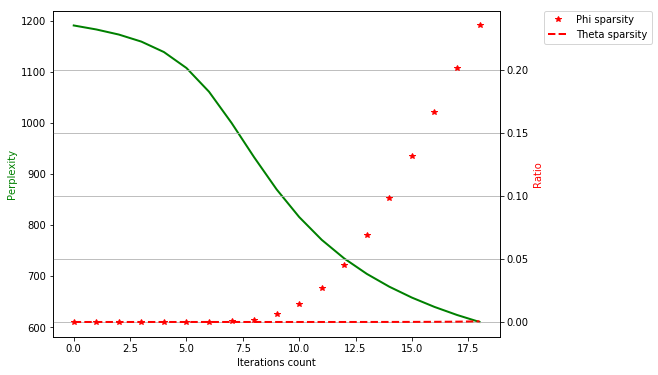

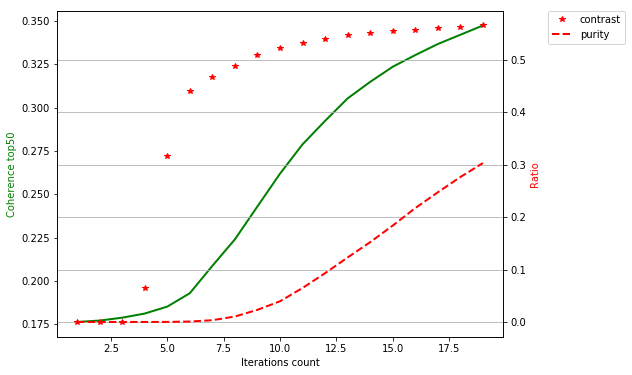

In [75]:
plot(model)

In [76]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=50)

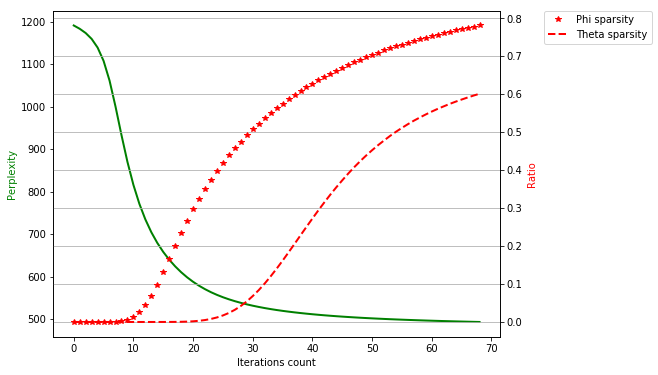

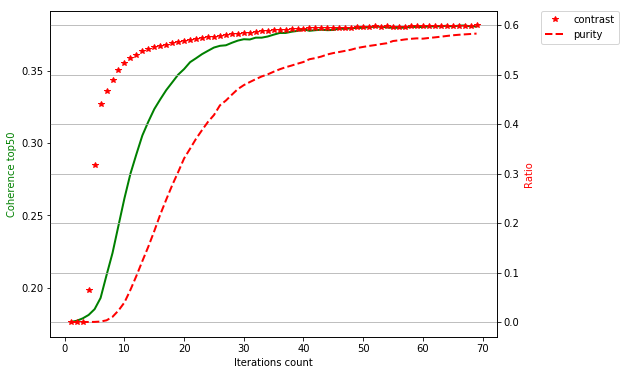

In [77]:
plot(model)

In [78]:
printTopics(model, topics_domain + topics_background)

topic_d0:[70/2368] операция обнаруживать информировать банк доступный тариф изменение уведомлять счет карта отражать информация условие баланс сайт взиматься средство дата получение комиссия размер использование интернет момент случай распространяться взимать расходный выписка клиент организация не остаток тп снятие уведомление тот такой план расчет наличие значиться совершение данный операция_совершать совершенный то совершаться отражение ознакомляться поздно который пункт сумма вознаграждение иб число отслеживать отсутствие день списание операция_совершение способ возмещение сохранять последний руб расход тарифный равный
topic_d1:[70/2926] банкомат деньги принимать вносить отделение внесение не купюра чек ситуация съедать вставлять город ул адрес терминал касса проблема один экран наличный офис располагать время прием надпись пр выплюнуть сломаться г день устройство д инкассация зависать же проглатывать рубль чека работа это ошибка зажевать и неделя нештатный москва центр рядом раз п

In [79]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=5000000, topic_names=topics_domain))

In [80]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=30)

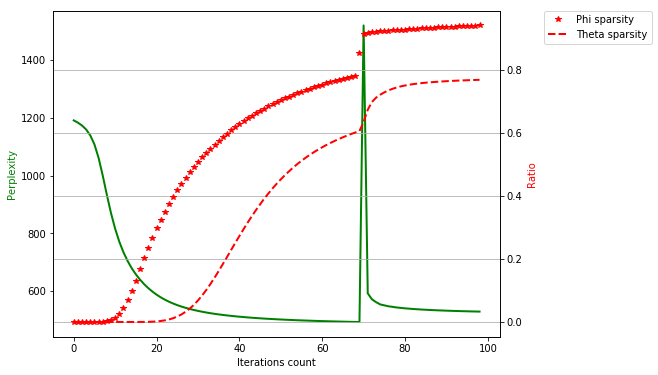

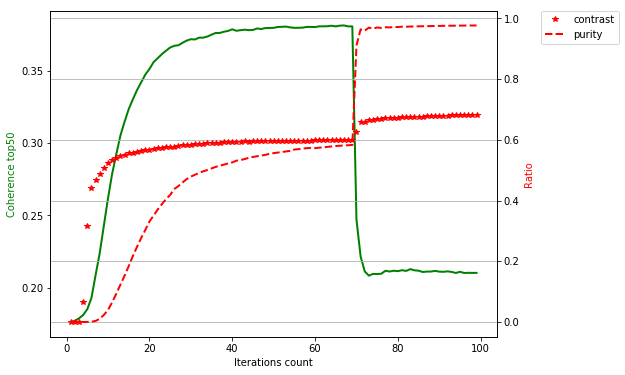

In [81]:
plot(model)

Посмотреть на топ-токены по темама-- интерпретируемость.
Можно выделять темы, но многие темы содержат негативный оттенок, что в принципе логично исходя из того, что много было отрицательных оценок у банка.

In [82]:
printTopics(model, topics_domain + topics_background)

topic_d0:[70/510] обнаруживать информировать доступный отражать вводить тп распространяться взимать расходный операция_совершать совершенный отражение несогласие вознаграждение введение взимание операция_совершение думаться держатель операция_совершенный мдм раздел стенд усугубляться удивление выводиться редакция прокатать просмотр обворовывать недополучать комиссионный версия зарезервировать учетный налетать невзирая революция пониматься тирада тщательный отображение общество заметно ведомость наличные_снятие различие аккуратно тсп внеочередной облагаться взимать_комиссия перечисленный полмиллиона типовой школа датироваться интернетбанк вступление слип возлагать цикл давний_клиент заботить интервал санкционировать нужда тот_число знакомить рассылаться
topic_d1:[70/1098] внесение купюра вставлять съедать пополнять располагать надпись экран зависать доезжать выплюнуть сломаться пр устройство чека инкассация проглатывать нештатный район зажевать засовывать оборудование сжирать починять г

Посмотремть насколько темы хорошо скоррелированы с оценками пользователей.
Можно увидеть, например, что topic_d87 имеет большой процент в оченке 5, посмотрем на этот топ-токен отдельно, действительно видно, что в нем сожержаться положительные слова благодарности итд. Аналогично с topic_d86. Наоборот же, topic_d82 сожержит много слов в оценке 1, что соотвествует действительности, т.к. слова достаточно негативные. По остальным темам, слова действительно, могут содержаться в разного рода отзывах. Так что некоторые темы хорошо скоррелированы с оценками пользователей.

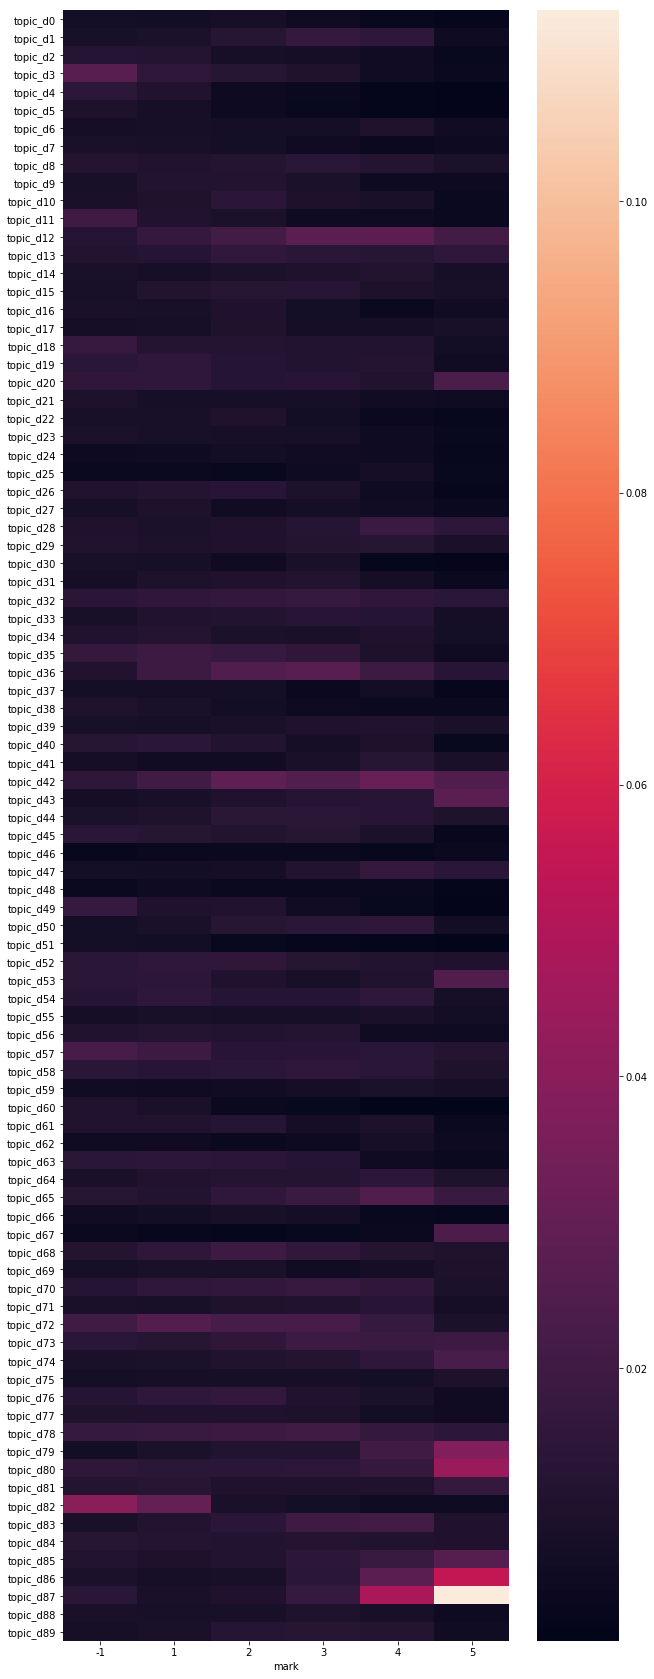

In [83]:
theta = model.get_theta()
theta = theta.transpose()[topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

In [84]:
model.save(FOLDER_DATA + "model")

In [85]:
sentiment = pd.read_excel(SENTIMENT_PATH, 
                          header=None)
mystem = Mystem()
sentiment[0] = sentiment[0].apply(lambda word: lemmatize(word, mystem)[0])
sentiment.head(10)

,0,1
0,абажур,0
1,абажур,0
2,абажур,-1
3,абориген,-1
4,абориген,-1
5,абориген,0
6,аборт,-2
7,аборт,0
8,аборт,-1
9,аборт,0


In [86]:
sentiment = sentiment.groupby(0).mean()
sentiment.columns = ["value"]
sentiment.value /= 2
sentiment.head(10)

,value
0,
абажур,-0.166667
абориген,-0.333333
аборт,-0.375000
абортивный,-0.125000
абсолютный,0.000000
абстрактный,0.000000
абсурд,-0.500000
абсурдность,-0.357143
абсурдный,-0.500000


In [87]:
vocab = getSetFromFile(VOCAB_PATH)
indexes = set(sentiment.index) & vocab
sentiment = sentiment.loc[indexes]
positive = set(sentiment[sentiment.value > 0].index)
negative = set(sentiment[sentiment.value < 0].index)
sentiment_dict = positive | negative
print "Всего тональных слов {}, из них положительной тональности - {}, \
отрицательной - {}".format(sum(sentiment.value != 0), len(positive), len(negative))

Всего тональных слов 1900, из них положительной тональности - 682, отрицательной - 1218


In [88]:
bv.dictionary.save_text(FOLDER_DATA + "all.txt")

In [89]:
ethnic_dict_name = 'sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(sentiment.loc[token].value)  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_sentiment = artm.Dictionary()
dictionary_sentiment.create(dictionary_data)

os.remove(os.path.join('{}.txt'.format(FOLDER_DATA + ethnic_dict_name)))
os.remove(os.path.join('{}.dict'.format(FOLDER_DATA + ethnic_dict_name)))

dictionary_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11705


In [90]:
ethnic_dict_name = 'non_sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(abs(sentiment.loc[token].value))  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_non_sentiment = artm.Dictionary()
dictionary_non_sentiment.create(dictionary_data)

os.remove(os.path.join('{}.txt'.format(FOLDER_DATA + ethnic_dict_name)))
os.remove(os.path.join('{}.dict'.format(FOLDER_DATA + ethnic_dict_name)))

dictionary_non_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_non_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11705


In [91]:
createTopics(domain_n=100, background_n=10, sentiment=True)

In [92]:
model_sentiment = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)

In [93]:
add_scores(model_sentiment)

In [94]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [95]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=80)

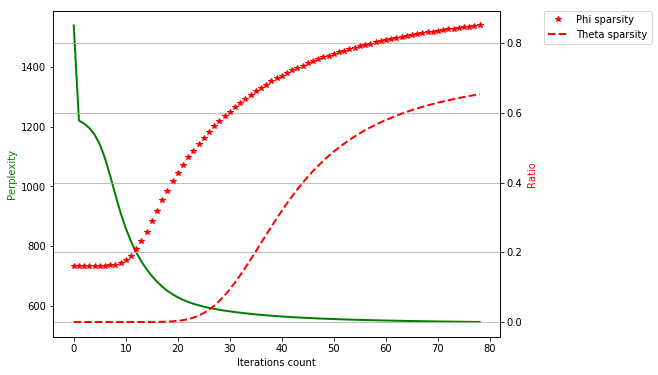

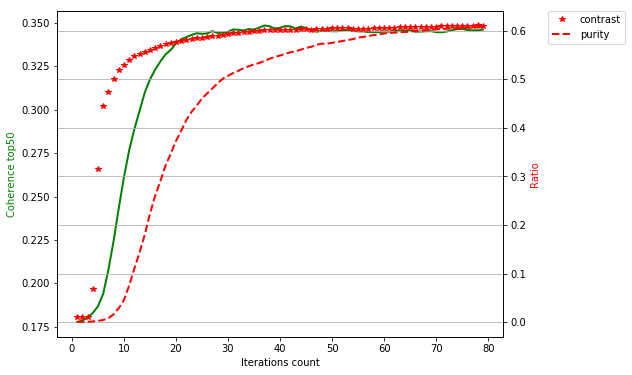

In [96]:
plot(model_sentiment)

In [97]:
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/678] сотрудник русский писать смочь нужный вернуть помогать подписывать возможность надеяться новый добрый спасибо касса хороший одобрять страховка довольный покупка понравиться всегда возврат искать интересный решаться встречать наш удобный рекомендовать нравиться поддержка согласный приятный мобильный впечатление желать помощь здравствовать подождать интересовать внимание стараться уважение открытие любить разный важный исправлять правда захотеть увеличивать муж пожалуйста вежливый нормальный радовать бонус подпись обязательство отзывчивый собственный уметь положительный полностью надежда извиняться доверять сосед верить гениальный
topic_neg:[70/1213] пользоваться заявление указывать отказываться много проблема оставлять пытаться начинаться списывать разбираться срок выясняться передавать проводить долг заявлять никакой выплачивать лицо сидеть забирать заплатить претензия занимать нарушать забывать отказ угроза продолжать ошибка жить потратить отдавать жалоба нарушение 

In [98]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=5000000, topic_names=topics_domain))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=5000, topic_names=topics_sentiment))

In [99]:
model_sentiment.regularizers['DecorrelatorSentiment'].tau = 500000

In [100]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=40)

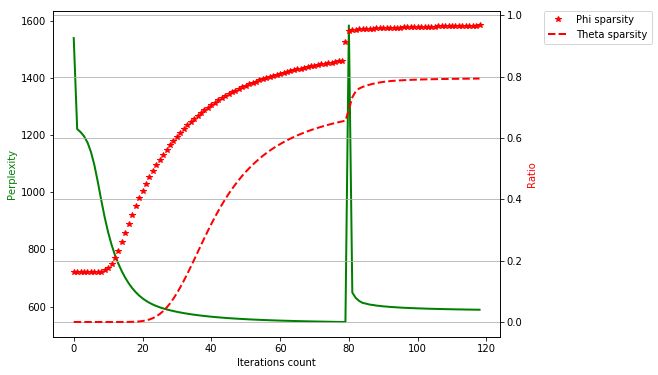

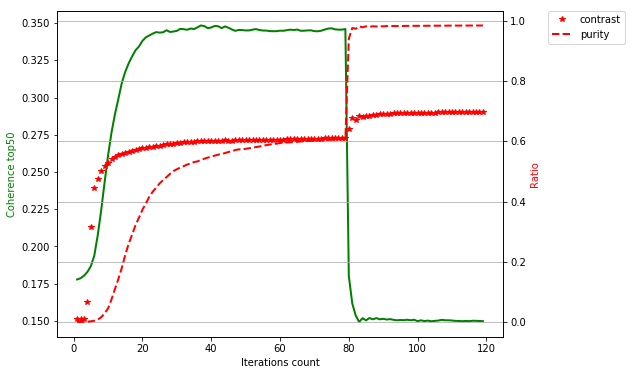

In [101]:
plot(model_sentiment)

In [102]:
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/678] сотрудник русский писать смочь нужный вернуть помогать подписывать возможность надеяться новый добрый спасибо касса хороший одобрять страховка довольный покупка понравиться всегда возврат искать интересный решаться встречать наш удобный рекомендовать нравиться поддержка согласный приятный мобильный впечатление желать помощь здравствовать подождать интересовать внимание стараться уважение открытие любить разный важный исправлять правда захотеть увеличивать муж пожалуйста вежливый нормальный радовать бонус подпись обязательство отзывчивый собственный положительный уметь полностью надежда извиняться доверять сосед верить гениальный
topic_neg:[70/1213] пользоваться заявление указывать отказываться много проблема оставлять пытаться начинаться списывать разбираться срок выясняться передавать проводить долг заявлять никакой выплачивать лицо сидеть забирать заплатить претензия занимать нарушать забывать отказ угроза продолжать ошибка жить потратить отдавать жалоба нарушение 

top_pos и top_neg сожержат подходящие слова и в положительных оценках преобладают слова из top_pos в негативных оценках из top_neg.

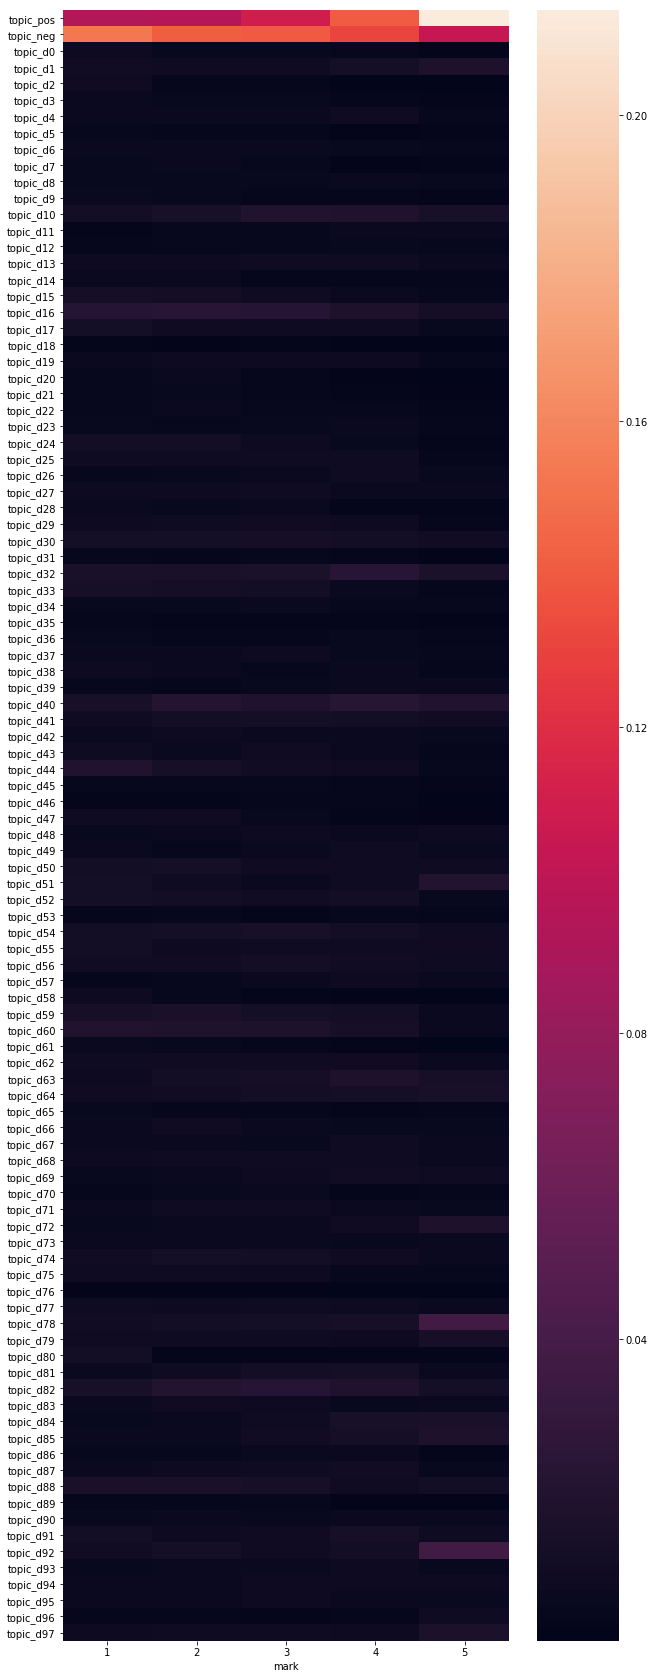

In [103]:
theta = model_sentiment.get_theta()
theta = theta.transpose()[topics_sentiment + topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
theta = theta[theta.mark != -1]
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

In [104]:
theta = model_sentiment.get_theta().loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}

In [105]:
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in tqdm_notebook(theta.transpose().iterrows()):
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.1 or negative > 0.1:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[int(index)].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

A Jupyter Widget

In [106]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

In [107]:
printTopics(model_sentiment, topics=topics_sentiment + topics_domain, print_file=True)

topic_pos:[70/678] сотрудник русский писать смочь нужный вернуть помогать подписывать возможность надеяться новый добрый спасибо касса хороший одобрять страховка довольный покупка понравиться всегда возврат искать интересный решаться встречать наш удобный рекомендовать нравиться поддержка согласный приятный мобильный впечатление желать помощь здравствовать подождать интересовать внимание стараться уважение открытие любить разный важный исправлять правда захотеть увеличивать муж пожалуйста вежливый нормальный радовать бонус подпись обязательство отзывчивый собственный положительный уметь полностью надежда извиняться доверять сосед верить гениальный
topic_neg:[70/1213] пользоваться заявление указывать отказываться много проблема оставлять пытаться начинаться списывать разбираться срок выясняться передавать проводить долг заявлять никакой выплачивать лицо сидеть забирать заплатить претензия занимать нарушать забывать отказ угроза продолжать ошибка жить потратить отдавать жалоба нарушение 

In [108]:
model_sentiment.save(FOLDER_DATA + "model_sentiment")

In [109]:
PATH_TO_WW_VW = FOLDER_DATA + 'ww_vw.txt'
FOLDER_BATCHES_WW = FOLDER_DATA + 'batches_wntm/'

In [110]:
checkDirectory(FOLDER_BATCHES_WW)
bv_ww = artm.BatchVectorizer(data_path=PATH_TO_WW_VW, data_format='vowpal_wabbit',
                             target_folder=FOLDER_BATCHES_WW)

In [111]:
createTopics(domain_n=100, background_n=10, sentiment=True)

In [112]:
model_ww = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)
add_scores(model_ww)

In [113]:
dictionary_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "sentiment.dict")
dictionary_non_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "non_sentiment.dict")

In [114]:
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=100))
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-100))
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-1000))

In [115]:
model_ww.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=50)

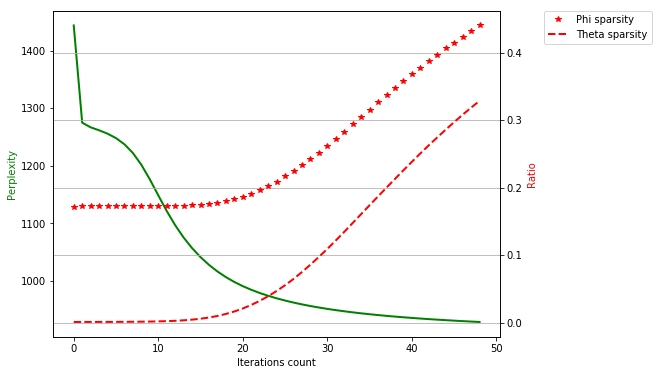

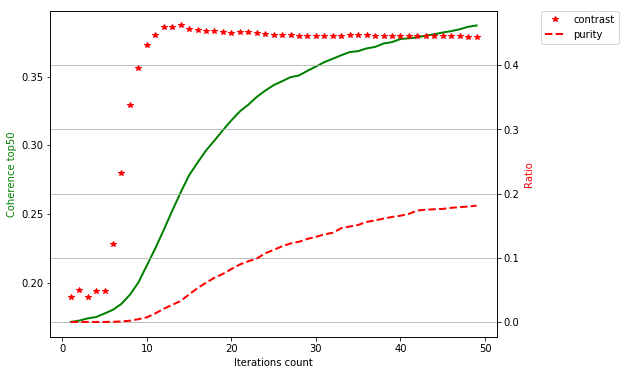

In [116]:
plot(model_ww)

In [117]:
printTopics(model_ww, topics_sentiment + topics_domain)

topic_pos:[70/7901] проблема одобрять проводить надеяться новый оставлять забирать занимать спасибо покупка имя хороший писать заявлять вернуть открытие начинаться наш отказываться возможность возврат разбираться встречать отказ искать помогать рекомендовать решаться нравиться понравиться пытаться поддержка подождать много смочь довольный жить впечатление потратить интересный помощь нужный подписывать сотрудник желать удобный всегда срок мобильный забывать руководитель согласный россия никакой касса интересовать лицо здравствовать увеличивать отдавать разный подпись внимание добрый выплачивать стараться доход важный надежда положительный
topic_neg:[70/8090] претензия разбираться долг начинаться продолжать нарушать попытка заплатить ошибка никакой выплачивать штраф отказ жалоба нарушение забывать заявлять отсутствовать подтверждение угроза проблема записывать русский отдавать обманывать допускать очередной набирать повторяться передавать хватить результат доводить доказывать заставлять 

In [118]:
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_ww.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_ww.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=500000, topic_names=topics_domain))
model_ww.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=50000, topic_names=topics_sentiment))

In [119]:
model_ww.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=50)

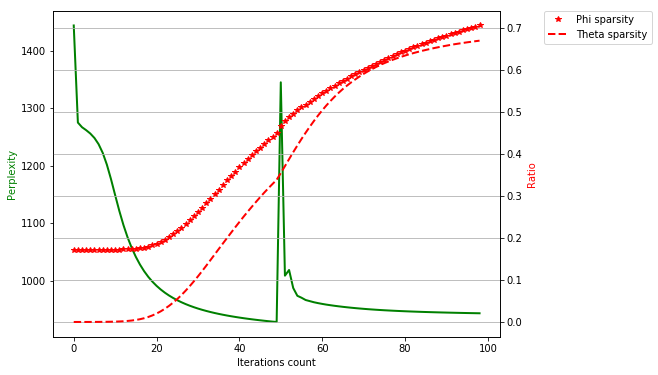

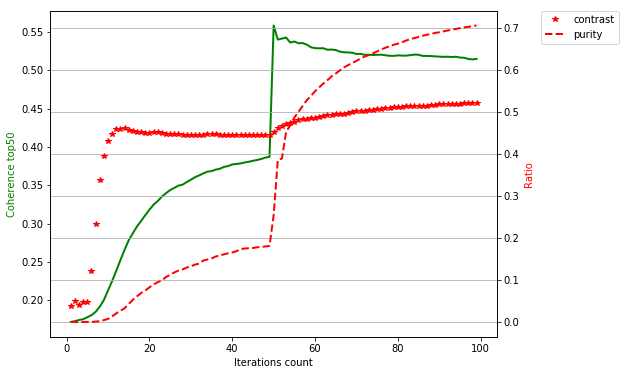

In [120]:
plot(model_ww)

In [121]:
printTopics(model_ww, topics_sentiment + topics_domain)

topic_pos:[70/3817] указывать проблема одобрять имя надеяться проводить новый занимать хотеть заявлять начинаться забирать спасибо вернуть покупка хороший разбираться возможность потратить возврат оставлять отказ открытие наш искать встречать касса банк жить писать рекомендовать решаться забывать отдавать много нравиться понравиться поддержка подождать довольный впечатление обслуживание оставаться интересный помощь просить никакой выплачивать желать работать удобный всегда мобильный исправлять руководитель согласный россия подпись заставлять интересовать подписывать здравствовать увеличивать разный внимание добрый стараться доход можно извиняться
topic_neg:[70/3757] претензия долг продолжать разбираться нарушать попытка ошибка заплатить штраф начинаться никакой жалоба выплачивать нарушение отсутствовать отказ угроза указывать русский обманывать записывать очередной набирать повторяться хватить доводить доказывать допускать результат расплачиваться подтверждение превышать персональный з

In [122]:
PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences.txt'
FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences/'
bv_sentences = artm.BatchVectorizer(data_path=PATH_TO_WW_SENTENCES, data_format='vowpal_wabbit', batch_size=10000,
                                        target_folder=FOLDER_BATCHES_SENTENCES)

In [123]:
theta = model_ww.transform(bv_sentences).loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}

In [124]:
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in tqdm_notebook(theta.transpose().iterrows()):
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.1 or negative > 0.1:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[sentences_replies.loc[int(index)].reply_id].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

A Jupyter Widget

In [125]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

In [126]:
model_ww.save(FOLDER_DATA + "model_ww")

In [127]:
PATH_TO_VW_SENTIMENT_NEW = FOLDER_DATA + 'vw_sentiment.txt'
FOLDER_BATCHES_SENTIMENT_NEW = FOLDER_BATCHES + 'sentiment_new/'

In [128]:
bv_sentiment = artm.BatchVectorizer(data_path=PATH_TO_VW_SENTIMENT_NEW, data_format="vowpal_wabbit",
                                    target_folder=FOLDER_BATCHES_SENTIMENT_NEW, gather_dictionary=True)

In [129]:
createTopics(domain_n=0, background_n=1, sentiment=True)

In [130]:
model_sentiment_new = artm.ARTM(topic_names=topics_sentiment + topics_background, dictionary=bv_sentiment.dictionary,
                            theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True, reuse_theta=True)

In [131]:
indexes = list(replies[replies.mark != -1].index)
doc_titles = map(str, indexes)
doc_coeff = []
marks = [[-1, 100, 0], [-1, 10, 0],  [-1, 1, 0], [10, -1, 0], [100, -1, 0]]
for index, mark in replies.loc[indexes].mark.iteritems():
    doc_coeff.append(marks[mark - 1])

In [132]:
add_scores(model_sentiment_new)

In [133]:
model_sentiment_new.regularizers.add(artm.SmoothSparseThetaRegularizer(name="SST", tau=1000, doc_titles=doc_titles,
                                                                       doc_topic_coef=doc_coeff))

In [134]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=50)

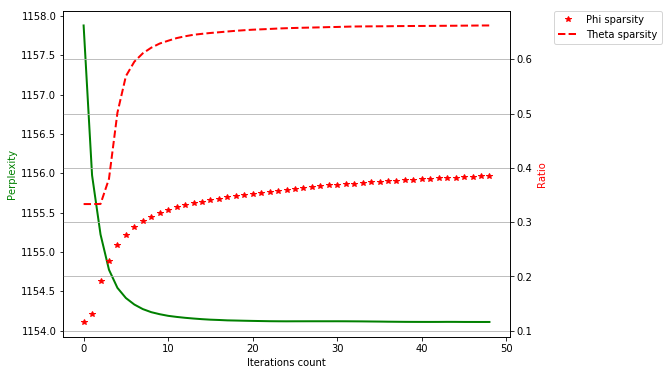

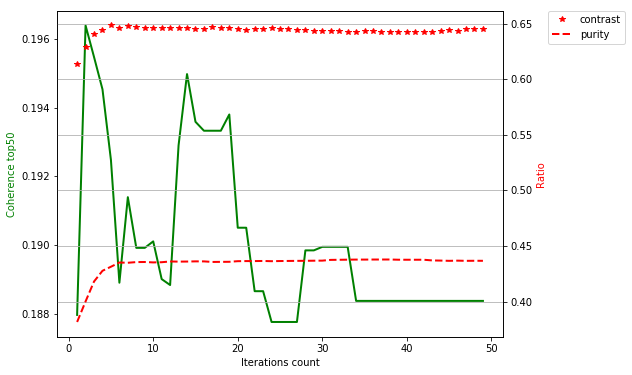

In [135]:
plot(model_sentiment_new)

In [136]:
model_sentiment_new.regularizers.add(artm.DecorrelatorPhiRegularizer(name="decorrelataion", tau=5e10,
                                                                 topic_names=topics_sentiment))

In [137]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=10)

In [138]:
model_sentiment_new.regularizers.add(artm.SmoothSparsePhiRegularizer("sparsePhi", topic_names=topics_sentiment[1],
                                                                 tau=-100))

In [139]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=1)

Негативные и позитивные слова разделились достаточно хорошо.

In [140]:
printTopics(model_sentiment_new, topics_sentiment, num=500)

topic_pos:[263/263] благодарность_выражать коллектив отзывчивый впечатление_поделиться доброжелательность атмосфера процветание актуально умение приводить_пример чувствоваться доходчиво коломна зуево поблагодарить_хотеть позитивный дружелюбный поприветствовать персонифицировать иваново приветливо внимательность калинин рост обсуживаться созревать отзывчивость путешествовать электросталь доброжелательно введы респект грамотность приветствовать отмечать_хотеться просторный лидер люберцы вопль тула пята тко балашиха конкурентоспособный осваивать ступино заметный настраиваться приготавливать испугать тупить тьфу немаловажный намечаться оптимальный противно внушать комфортно посад портфель хлебать отп признательность маловато неизменный незаметно доживать чуткий обходительный выражать_признательность выражать_коллектив карьерный перебираться обаятельный повсюду рка отзваниваться доступно_объяснять интуитивно уютно благодарность_признательность угощать далековато резервировать огромный_спаси